In [2]:
#!/usr/bin/env python3
"""
Check whether the true output‑neuron ordering minimises the Frobenius‑norm
 distance to a reference geometry, compared either with a fixed number of
 random permutations **or with *all* possible permutations**, controlled by
 the ``ALL_PERMS`` flag.
"""

import itertools
import math
import random
from pathlib import Path

import numpy as np
import torch

# ----------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------
MODEL_TYPE   = "fully_connected_dropout"
DATASET_TYPE = "mnist"
HIDDEN_DIM   = "[50,50]"
UNTRAINED    = False

REFERENCE_SEEDS = range(0, 1)
TEST_SEEDS      = range(10, 15)
N_RANDOM_PERMS  = 100_000
ALL_PERMS       = False
SAVE_DISTANCES  = True

BASEDIR = Path("../underlying/saved_models")
UNTRAINED_SUFFIX = "-untrained" if UNTRAINED else ""
MODEL_FMT = f"{MODEL_TYPE}-{DATASET_TYPE}{UNTRAINED_SUFFIX}-hidden_dim_{HIDDEN_DIM}/seed-{{seed}}"

rng = np.random.default_rng(42)

# ----------------------------------------------------------------------
# Helper functions
# ----------------------------------------------------------------------

def load_last_layer(seed: int) -> np.ndarray:
    """Load last-layer weight matrix (shape: [num_classes, hidden])."""
    path = BASEDIR / MODEL_FMT.format(seed=seed)
    ckpt = torch.load(path, map_location="cpu")
    w = ckpt["layers.2.weight"].cpu().detach().numpy()  # shape [C, H]
    # L2‑normalise rows so cosine similarity == dot product
    w /= np.linalg.norm(w, axis=1, keepdims=True) + 1e-12
    return w


def gram(w: np.ndarray) -> np.ndarray:
    """Return the CxC Gram matrix of row-normalised weights."""
    return w @ w.T                                    # cosine similarities


def random_permutation(c: int) -> np.ndarray:
    """Return a random permutation array of 0…c-1."""
    return rng.permutation(c)


def frob(A: np.ndarray, B: np.ndarray) -> float:
    """Frobenius-norm distance ‖A-B‖_F."""
    return np.linalg.norm(A - B, ord="fro")

# ----------------------------------------------------------------------
# 1) Build reference Gram matrix (mean over reference seeds)
# ----------------------------------------------------------------------
print("Building reference geometry …")
ref_grams = [gram(load_last_layer(s)) for s in REFERENCE_SEEDS]
G_ref = np.mean(ref_grams, axis=0)       # still PSD, see discussion

C = G_ref.shape[0]                       # number of classes / output neurons
print(f"  → Averaged over {len(REFERENCE_SEEDS)} seeds, C = {C}\n")

if ALL_PERMS:
    total_perms = math.factorial(C)
    print(f"Evaluating ALL permutations: {total_perms:,} possibilities per seed - may take a while!\n")
else:
    print(f"Evaluating {N_RANDOM_PERMS:,} random permutations per seed.\n")

# ----------------------------------------------------------------------
# 2) Evaluate each test seed
# ----------------------------------------------------------------------

def permutation_iterator() -> itertools.chain:
    """Yield permutations according to ALL_PERMS flag."""
    if ALL_PERMS:
        return itertools.permutations(range(C))
    # else
    return (random_permutation(C) for _ in range(N_RANDOM_PERMS))


hit_counter = 0
best_permutations = []
distances = []

TOL = 1e-13

for seed in TEST_SEEDS:
    W_test = load_last_layer(seed)
    G_test = gram(W_test)

    d_true = frob(G_ref, G_test)

    # Track best distances and permutations
    best_dist  = d_true
    best_perms = [np.arange(C)]        # start with the true ordering
    distances_current_seed = []

    worse_count = 0
    for p in permutation_iterator():
        p = np.asarray(p, dtype=int)
        #G_perm = G_test[p][:, p]
        W_perm = W_test[p]
        G_perm = gram(W_perm)
        d_perm = frob(G_ref, G_perm)

        if SAVE_DISTANCES:
            distances_current_seed.append(d_perm)

        # Update running best
        if d_perm < best_dist - TOL:
            best_dist  = d_perm
            best_perms = [p]    
            worse_count += 1
        elif abs(d_perm - best_dist) <= TOL:
            best_perms.append(p)
            

    is_best = (worse_count == 0)
    hit_counter += is_best

    best_permutations.append(best_perms)
    distances.append(distances_current_seed)

    print(f"Seed {seed:3d}: "
          f"d_true = {d_true:8.4f}  |  "
          f"perms better = {worse_count:4d} / "
          f"{'all' if ALL_PERMS else N_RANDOM_PERMS}  "
          f"→ {'✓ best' if is_best else '✗ not best'}")

# ----------------------------------------------------------------------
# 3) Summary
# ----------------------------------------------------------------------
print(f"\nOriginal ordering was the unique best in "
      f"{hit_counter} / {len(TEST_SEEDS)} test seeds.")

Building reference geometry …
  → Averaged over 1 seeds, C = 10

Evaluating 100,000 random permutations per seed.

Seed  10: d_true =   1.0843  |  perms better =    0 / 100000  → ✓ best
Seed  11: d_true =   0.9533  |  perms better =    0 / 100000  → ✓ best
Seed  12: d_true =   0.9421  |  perms better =    0 / 100000  → ✓ best
Seed  13: d_true =   0.9238  |  perms better =    0 / 100000  → ✓ best
Seed  14: d_true =   0.8997  |  perms better =    0 / 100000  → ✓ best

Original ordering was the unique best in 5 / 5 test seeds.


In [8]:
# ----------------------------------------------------------------------
# Accuracy over best_permutations
# ----------------------------------------------------------------------
identity = np.arange(C)

# collect per-permutation accuracies, then average
perm_accs = [
    (perm == identity).mean()          # fraction of correct positions
    for perms_for_seed in best_permutations
    for perm in perms_for_seed
]

acc_mean = np.mean(perm_accs)
acc_std = np.std(perm_accs)

print(f"\nAverage position-wise accuracy of best permutations: {acc_mean:.4f}")



Average position-wise accuracy of best permutations: 0.8889


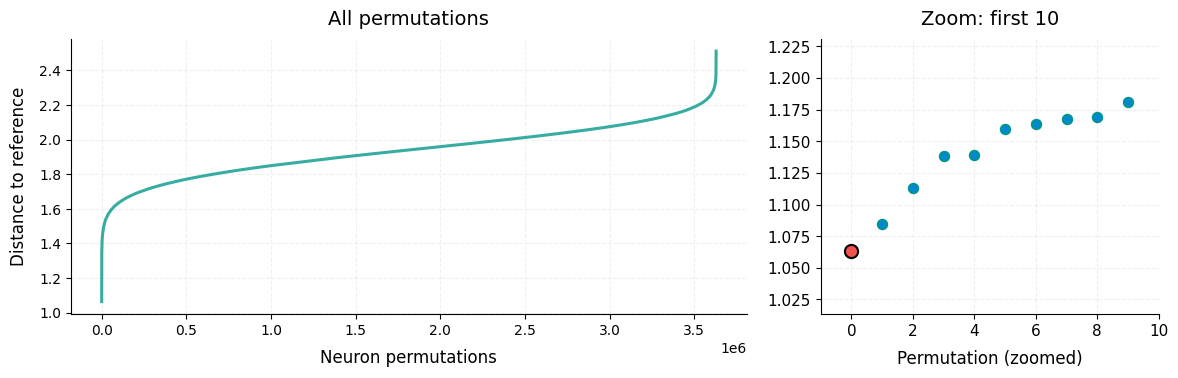

In [9]:
import matplotlib.pyplot as plt
import numpy as np


sorted_distances = np.sort(distances[0])

fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

main_color = "#26a69a"   # teal
dot_color = "#0288d1"    # blue
highlight_color = "#ef5350"  # red/pink for highlight

# Full plot (left)
axs[0].plot(
    sorted_distances,
    color=main_color,
    linewidth=2.2,
    alpha=0.92,
)
axs[0].set_xlabel("Neuron permutations", fontsize=12, labelpad=8)
axs[0].set_ylabel("Distance to reference", fontsize=12, labelpad=8)
axs[0].set_title("All permutations", fontsize=14, pad=10)
axs[0].grid(alpha=0.18, linestyle="--")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

# Zoomed plot (right)
zoomed_xlim = 10
axs[1].scatter(
    np.arange(1, zoomed_xlim),      # All except index 0
    sorted_distances[1:zoomed_xlim],
    color=dot_color,
    s=48,
    edgecolor="#009688",
    linewidth=1.3,
    zorder=2,
)
# Highlight index 0
axs[1].scatter(
    0,
    sorted_distances[0],
    color=highlight_color,
    s=90,
    edgecolor="black",
    linewidth=1.5,
    zorder=3,
    label="Permutation 0"
)
axs[1].set_xlim(-1, zoomed_xlim)
axs[1].set_ylim(sorted_distances[:zoomed_xlim].min() - 0.05, sorted_distances[:zoomed_xlim].max() + 0.05)
axs[1].set_xlabel("Permutation (zoomed)", fontsize=12, labelpad=8)
axs[1].set_title(f"Zoom: first {zoomed_xlim}", fontsize=14, pad=10)
axs[1].grid(alpha=0.18, linestyle="--")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].tick_params(axis="both", which="major", labelsize=11)

# Optional: show legend only if you want
# axs[1].legend(loc="upper left", fontsize=10, frameon=False)

plt.tight_layout(pad=1.5)
plt.show()